In [143]:
import nibabel as nib
import nibabel.gifti
import nilearn
from nilearn import datasets, plotting
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import pylab as plt
from matplotlib.colors import ListedColormap
mpl.rcParams['svg.fonttype'] = 'none'

import sys
sys.path.append('/home/romy.beaute/projects/hypnomed/diffusion_embedding/helper_functions/')
sys.path.append('/mnt/data/romy/hypnomed/git/diffusion_embedding/helper_functions/')
from viz import *

import matplotlib.colors as colors




from scipy.io import loadmat
import nilearn
import nilearn.plotting
import numpy as np
import nibabel as nib
import pandas as pd
import os 

os.chdir('/mnt/data/romy/hypnomed/git/diffusion_embedding/visualize_emb_output')
print(os.getcwd())

import sys
sys.path.append('/home/romy.beaute/projects/hypnomed/diffusion_embedding/')
sys.path.append('/mnt/data/romy/hypnomed/git/diffusion_embedding/')

from emb_matrices.emb_matrices import *

/mnt/data/romy/hypnomed/git/diffusion_embedding/visualize_emb_output


In [144]:



####### TO DEFINE #######
gradients_for = 'states' #'blocks'
if gradients_for == 'states':
    emb_condition = 'control_meditation_hypnose'
else: #gradients_for == 'blocks' (controling for order effect)
    emb_condition = 'run-1_run-2_run-3'


#########################

npy_folder = '/mnt/data/romy/hypnomed/git/diffusion_embedding/emb_outputs/emb_output_{}'.format(gradients_for)

mesh = 'fsaverage5' #the low-resolution fsaverage5 mesh (10242 nodes = vertices per hemisphere)
fsaverage_path = '/mnt/data/romy/packages/freesurfer/subjects/{}/label'.format(mesh)
image_output_folder = '/mnt/data/romy/hypnomed/git/diffusion_embedding/visualize_emb_output/images_gradients/{}'.format(gradients_for) #where to store the visualisations of the gradient(s)



# Load Freesurfer fsaverage surface with read_label : return array with indices of vertices included in label
lab_lh = nib.freesurfer.read_label(fsaverage_path+'/lh.cortex.label') #shape = (9361,)
lab_rh = 10242 + nib.freesurfer.read_label(fsaverage_path+'/rh.cortex.label') #shape = (9361,)
lab= np.concatenate((lab_lh,lab_rh))



In [145]:
df = pd.read_csv('/mnt/data/romy/hypnomed/git/diffusion_embedding/scripts/subject_list.txt', header=None) #list of the subjects we have

sublist = np.asarray(df).flatten()
print(len(sublist))


if len(sublist) > 1:
    prefix = 'group' #group-level analysis
    image_folder = os.path.join(image_output_folder,prefix)
else:
    prefix = sublist[0] #indiv-level analysis
    image_folder = os.path.join(image_output_folder+'/indivs',prefix)
print('Gradient for : ',prefix)

image_folder = os.path.join(image_output_folder,prefix)
if not os.path.isdir(image_folder):
    os.makedirs(image_folder)

mat_folder = '/mnt/data/romy/hypnomed/git/diffusion_embedding/emb_matrices/{}'.format(prefix)
if not os.path.isdir(mat_folder):
    os.makedirs(mat_folder)

indiv_emb_states = emb_condition.split('_')
print(indiv_emb_states)

40
Gradient for :  group
['control', 'meditation', 'hypnose']


In [49]:
indiv_emb_state = 'control'
mat_file = mat_folder+'/{}_{}_embedding.mat'.format(prefix, indiv_emb_state)
print(mat_file)

b = loadmat(mat_file)
print('Loading ',mat_file)

print(70*'-')
print('Description {} : '.format(mat_file))
for k in b.keys():
    print('- {} :\n {}\n'.format(k,b[k]))
print('- b embedding shape : ',b['emb'].shape)
print('     ---> n_subjects = ',b['emb'].shape[0])
print('     ---> n_nodes = ',b['emb'].shape[1])
print('     ---> n_dimensions = ',b['emb'].shape[2])
print(70*'-')

b['emb'].shape  #(n_subjects,n_nodes,n_dims)
n_dims = b['emb'].shape[2]

a = np.zeros(20484) #size concatenated vertices from fsaverage5 template
mean_embs = np.mean(b['emb'],axis=0) #mean embeddings for each dimension, across subjects (axis=0 signifies avg across subjects, which is the first dimension of b)
a[lab]=np.mean(b['emb'],axis=0)[:,0] #check if corresponds to 1st gradient


/mnt/data/romy/hypnomed/git/diffusion_embedding/emb_matrices/group/group_control_embedding.mat
Loading  /mnt/data/romy/hypnomed/git/diffusion_embedding/emb_matrices/group/group_control_embedding.mat
----------------------------------------------------------------------
Description /mnt/data/romy/hypnomed/git/diffusion_embedding/emb_matrices/group/group_control_embedding.mat : 
- __header__ :
 b'MATLAB 5.0 MAT-file Platform: posix, Created on: Mon Jul  4 15:27:57 2022'

- __version__ :
 1.0

- __globals__ :
 []

- emb :
 [[[ 2.67402636 -0.43371909 -1.90566278 -1.96258209  0.96269637]
  [ 2.58394367 -0.52163341 -1.69402329 -1.47569082  0.52279159]
  [ 2.34598777 -0.53397088 -1.50247165 -1.21210487  0.43001069]
  ...
  [-0.11564092 -0.79164238 -0.7378136   1.67836119  2.42552838]
  [-0.2711239  -0.83115842 -0.63241028  2.30803548  3.00692461]
  [-0.40997833 -0.85253588 -0.48674388  2.92533958  3.47796838]]

 [[ 4.75234516 -0.25683267 -1.52032171  0.63574664 -1.16531714]
  [ 4.36789099 -0.

In [146]:
def imageCrop(filename):

    from PIL import Image

    i1 = Image.open(filename)
    i2 = np.array(i1)
    i2[i2.sum(axis=2) == 255*4,:] = 0
    i3 = i2.sum(axis=2)
    x = np.where((i3.sum(axis=1) != 0) * 1)[0]
    y = np.where((i3.sum(axis=0) != 0) * 1)[0]

    result = Image.fromarray(i2[x.squeeze()][:,y.squeeze()])
    result.save(filename)

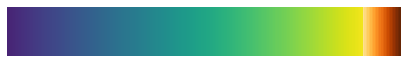

In [147]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('nipy_spectral')
new_cmap = truncate_colormap(cmap, 0.2, 0.95)

#colors1 = plt.cm.YlGnBu(np.linspace(0, 1, 128))
first = int((128*2)-np.round(255*(1.-0.90)))
second = (256-first)
#colors2 = new_cmap(np.linspace(0, 1, first))
colors2 = plt.cm.viridis(np.linspace(0.1, .98, first))
colors3 = plt.cm.YlOrBr(np.linspace(0.25, 1, second))
colors4 = plt.cm.PuBu(np.linspace(0., 0.5, second))
#colors4 = plt.cm.pink(np.linspace(0.9, 1., second))
# combine them and build a new colormap
cols = np.vstack((colors2,colors3))
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', cols)

num = 256
gradient = range(num)
for x in range(5):
    gradient = np.vstack((gradient, gradient))

fig, ax = plt.subplots(nrows=1)
ax.imshow(gradient, cmap=mymap, interpolation='nearest')
ax.set_axis_off()
fig.tight_layout()

plt.show()

# Visualize surfaces

In [148]:
import h5py, sys, io, numpy as np
import nibabel as nib

#https://nilearn.github.io/dev/modules/generated/nilearn.plotting.plot_surf_stat_map.html

print(type(a)) #stat_map Numpy array with a value for each vertex of the surf_mesh

<class 'pandas.core.series.Series'>


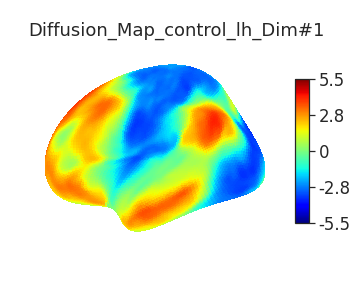

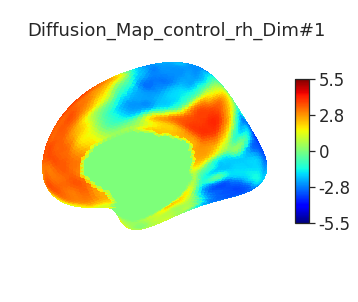

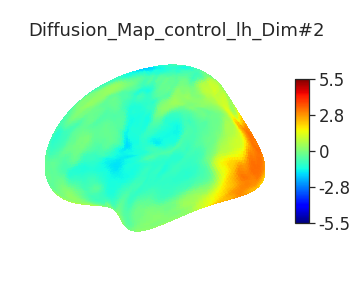

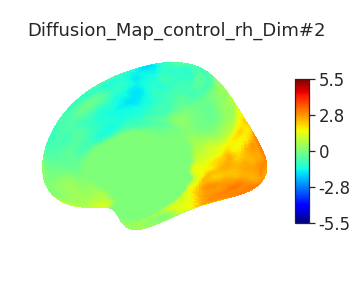

In [151]:
n_dims = 2

for dim in range(n_dims):

    a = np.zeros(20484) #size concatenated vertices from fsaverage5 template
    mean_embs = np.mean(b['emb'],axis=0) #mean embeddings for each dimension, across subjects (axis=0 signifies avg across subjects, which is the first dimension of b)
    a[lab]=np.mean(b['emb'],axis=0)[:,dim] #check if corresponds to 1st gradient

    surf_mesh_l = '/mnt/data/romy/packages/freesurfer/subjects/fsaverage5/surf/lh.inflated' #Surface mesh geometry
    stat_map_l = a[:10242] #Statistical map to be displayed on the surface mesh

    surf_mesh_r = '/mnt/data/romy/packages/freesurfer/subjects/fsaverage5/surf/rh.inflated' #Surface mesh geometry
    stat_map_r = a[10242:] #Statistical map to be displayed on the surface mesh

    title_r='Diffusion_Map_{}_rh_Dim#{}'.format(indiv_emb_state,dim+1)
    title_l='Diffusion_Map_{}_lh_Dim#{}'.format(indiv_emb_state,dim+1)


    nilearn.plotting.plot_surf_stat_map(surf_mesh_l,stat_map_l,bg_on_stat=True,showall=True,colorbar=True,cmap='jet', vmax=5.5,title=title_l,bg_scaling_factor=1.5)
    nilearn.plotting.plot_surf_stat_map(surf_mesh_r,stat_map_r,bg_on_stat=True,showall=True,colorbar=True,cmap='jet', vmax=5.5,title=title_r,bg_scaling_factor=1.5)

    # nilearn.plotting.plot_surf_stat_map('/mnt/data/romy/packages/freesurfer/subjects/fsaverage5/surf/rh.inflated',a[10242:],colorbar=True, cmap='jet', vmax=5.5,title='{}_diffusion_map_{}_rh_DIMENSION#{}'.format(prefix,indiv_emb_state,dim+1))


In [ ]:
# # showSurf(dataL[:,i].squeeze(), surfL, sulcL, cortL, showall=True, output_file='gradient_data/figures/embedded/fig.hcp.embed.%i.L' % i, symmetric_cbar = False,
# #                         cmap=mymap, bg_scaling_factor=1.5)

# i = 1 #change après, dimension du gradient sélectionné
# surfL = '/mnt/data/romy/packages/freesurfer/subjects/fsaverage5/surf/lh.inflated'
# showSurf(a[:10242].squeeze(), surfL, sulcL, cortL, showall=True, output_file='gradient_data/figures/embedded/fig.hcp.embed.%i.L' % i, symmetric_cbar = False,
#                         cmap=mymap, bg_scaling_factor=1.5)

# Scatterplot of first two dimensions


In [152]:

import seaborn as sns

sns.set(style="white")
sns.set_context("notebook", font_scale=1.5)

df = pd.DataFrame()

In [153]:

b['emb'].shape  #(n_subjects,n_nodes,n_dims)
n_dims = b['emb'].shape[2]

a = np.zeros(20484) #size concatenated vertices from fsaverage5 template
mean_embs = np.mean(b['emb'],axis=0) #mean embeddings for each dimension, across subjects (axis=0 signifies avg across subjects, which is the first dimension of b)
print(mean_embs.shape)

#a[lab]=np.mean(b['emb'],axis=0)[:,0] #check if corresponds to 1st gradient


(18715, 5)


### Correspondance Marguiles notion / perso notations : 

- cortL = lab_lh
- cort = lab_rh
- cortLen = lab

(To validate)

In [154]:

# cortLen = len(cortL) + len(cortR)
# df['e0'] = np.array(emb[range(cortLen),0])
# df['e1'] = np.array(emb[range(cortLen),1]) * -1 # to reorient plot


lab_lh = nib.freesurfer.read_label(fsaverage_path+'/lh.cortex.label') #shape = (9361,)
lab_rh = 10242 + nib.freesurfer.read_label(fsaverage_path+'/rh.cortex.label') #shape = (9361,)
lab = np.concatenate((lab_lh,lab_rh))

dimensions = ['e0','e1']

df[dimensions[0]] =  np.mean(b['emb'],axis=0)[:,0]
df[dimensions[1]] = np.mean(b['emb'],axis=0)[:,1] * -1 # to reorient plot

In [155]:
import matplotlib.cm as cm

norm_1 = mpl.colors.Normalize(vmin=df['e0'].min(), vmax=df['e0'].max())
cmap_1 = cm.Purples #cm.Reds
map_1 = cm.ScalarMappable(norm=norm_1, cmap=cmap_1)

norm_2 = mpl.colors.Normalize(vmin=df['e1'].min(), vmax=df['e1'].max())
cmap_2 = cm.Greens
map_2 = cm.ScalarMappable(norm=norm_2, cmap=cmap_2)

norm_3 = mpl.colors.Normalize(vmin=df['e1'].max() * -1, vmax=df['e1'].min() * -1)
cmap_3 = cm.Blues
map_3= cm.ScalarMappable(norm=norm_3, cmap=cmap_3)

c = np.ones(map_1.to_rgba(df['e0']).shape)

a = df['e1'].copy()
a = a - a.min() 
a = a / a.max()
c[:,1] = a

a = df['e1'].copy() * -1
a = a - a.min() 
a = a / a.max()
c[:,2] = a

a = df['e0'].copy()
a = a - a.min() 
a = a / a.max()
c[:,0] = a
c[:,1] = c[:,1] * ((a - 1) *  -1)
c[:,2] = c[:,2] * ((a - 1) *  -1)

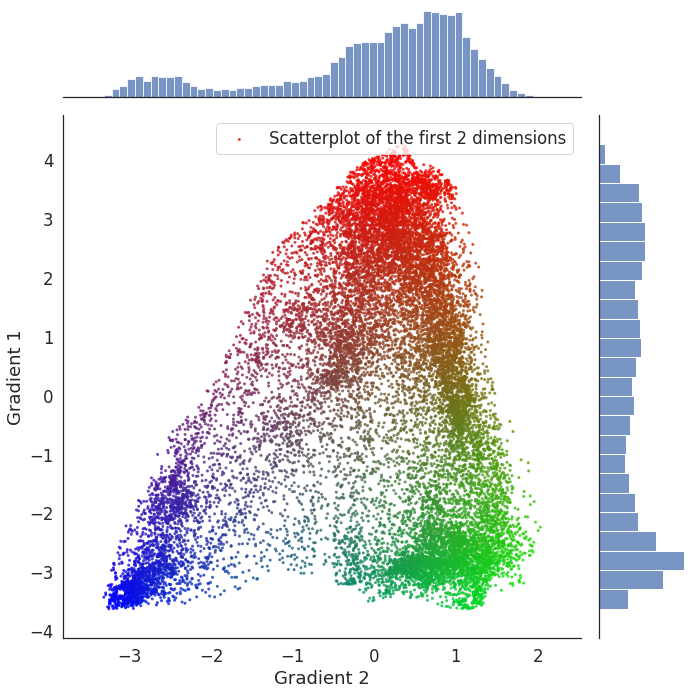

In [157]:
sns.set_context(font_scale=2)
g = (sns.jointplot(data=df, 
                   x = 'e1',
                   y='e0',
                   height=10, 
                   label='Scatterplot of the first 2 dimensions', 
                   linewidth=0, marker='.', 
                   #palette = dic,
                   #color=np.array(c), 
                   joint_kws={'color':None, 'c':c.tolist()},
                   alpha=0.8,
                   ylim = [np.min(df['e0']) - 0.5, np.max(df['e0']) + 0.5], 
                   xlim=[np.min(df['e1']) - 0.5, np.max(df['e1']) + 0.5]).set_axis_labels('Gradient 2', 'Gradient 1'))

In [175]:
from plot_helpers import *

images_path = os.path.join(os.getcwd(),'scatter_embedded')
print(images_path)
list_scatters = os.listdir(images_path)
list_titles = [list_scatters[t].split('.')[0] for t in range(len(list_scatters))]

show_image_list(list_scatters, 
                list_titles,
                num_cols=2,
                figsize=(20, 10),
                grid=False,
                title_fontsize=20)



/mnt/data/romy/hypnomed/git/diffusion_embedding/visualize_emb_output/scatter_embedded


AssertionError: 

In [178]:
!conda install Pillow
from PIL import Image
from numpy import asarray


for im in list_scatters:
    image = Image.open(im)

    # summarize some details about the image
    print(image.format)
    print(image.size)
    print(image.mode)

    numpydata = asarray(image)
    print(type(numpydata))
    print(numpydata.shape)

#list_scatters


# >>>>>>>>>>>>>>>>>>>>>> ERROR REPORT <<<<<<<<<<<<<<<<<<<<<<

    Traceback (most recent call last):
      File "/home/romy.beaute/anaconda3/lib/python3.9/site-packages/conda/core/subdir_data.py", line 704, in fetch_repodata_remote_request
        resp.raise_for_status()
      File "/home/romy.beaute/anaconda3/lib/python3.9/site-packages/requests/models.py", line 960, in raise_for_status
        raise HTTPError(http_error_msg, response=self)
    requests.exceptions.HTTPError: 404 Client Error: Not Found for url: https://repo.anaconda.com/pkgs/free/noarch/current_repodata.json
    
    During handling of the above exception, another exception occurred:
    
    Traceback (most recent call last):
      File "/home/romy.beaute/anaconda3/lib/python3.9/site-packages/requests/models.py", line 910, in json
        return complexjson.loads(self.text, **kwargs)
      File "/home/romy.beaute/anaconda3/lib/python3.9/site-packages/simplejson/__init__.py", line 525, in loads
        return _defaul